In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.discrete.discrete_model import Probit
import matplotlib.pyplot as plt

In [2]:
USREC = pd.read_csv('../data/USREC.csv')
df = pd.read_csv('../data/T10Y3MM.csv')

# Use data since 1982
USREC = USREC[USREC['DATE'].map(lambda x: int(x[:4])) >= 1982]
# Combine data
df['USREC'] = list(USREC['USREC'])

# Separate df
training_df = df.loc[:275].copy()
testing_df = df.loc[276:].copy()

# Preview
df.head()

,DATE,T10Y3MM,USREC
0,1982-01-01,1.67,1
1,1982-02-01,0.15,1
2,1982-03-01,0.55,1
3,1982-04-01,0.53,1
4,1982-05-01,0.91,1


## Probit using T10Y3MM with all samples since 1982

In [3]:
# Probit fit
model = Probit(df['USREC'], df['T10Y3MM']).fit()
df['y_hat'] = model.predict(df['T10Y3MM'])
model.summary()

Optimization terminated successfully.
         Current function value: 0.466029
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                  USREC   No. Observations:                  474
Model:                         Probit   Df Residuals:                      473
Method:                           MLE   Df Model:                            0
Date:                Wed, 28 Jul 2021   Pseudo R-squ.:                 -0.2140
Time:                        18:44:44   Log-Likelihood:                -220.90
converged:                       True   LL-Null:                       -181.97
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T10Y3MM       -0.4895      0.038    -12.837      0.000      -0.564      -0.415
==============================================================================
"""

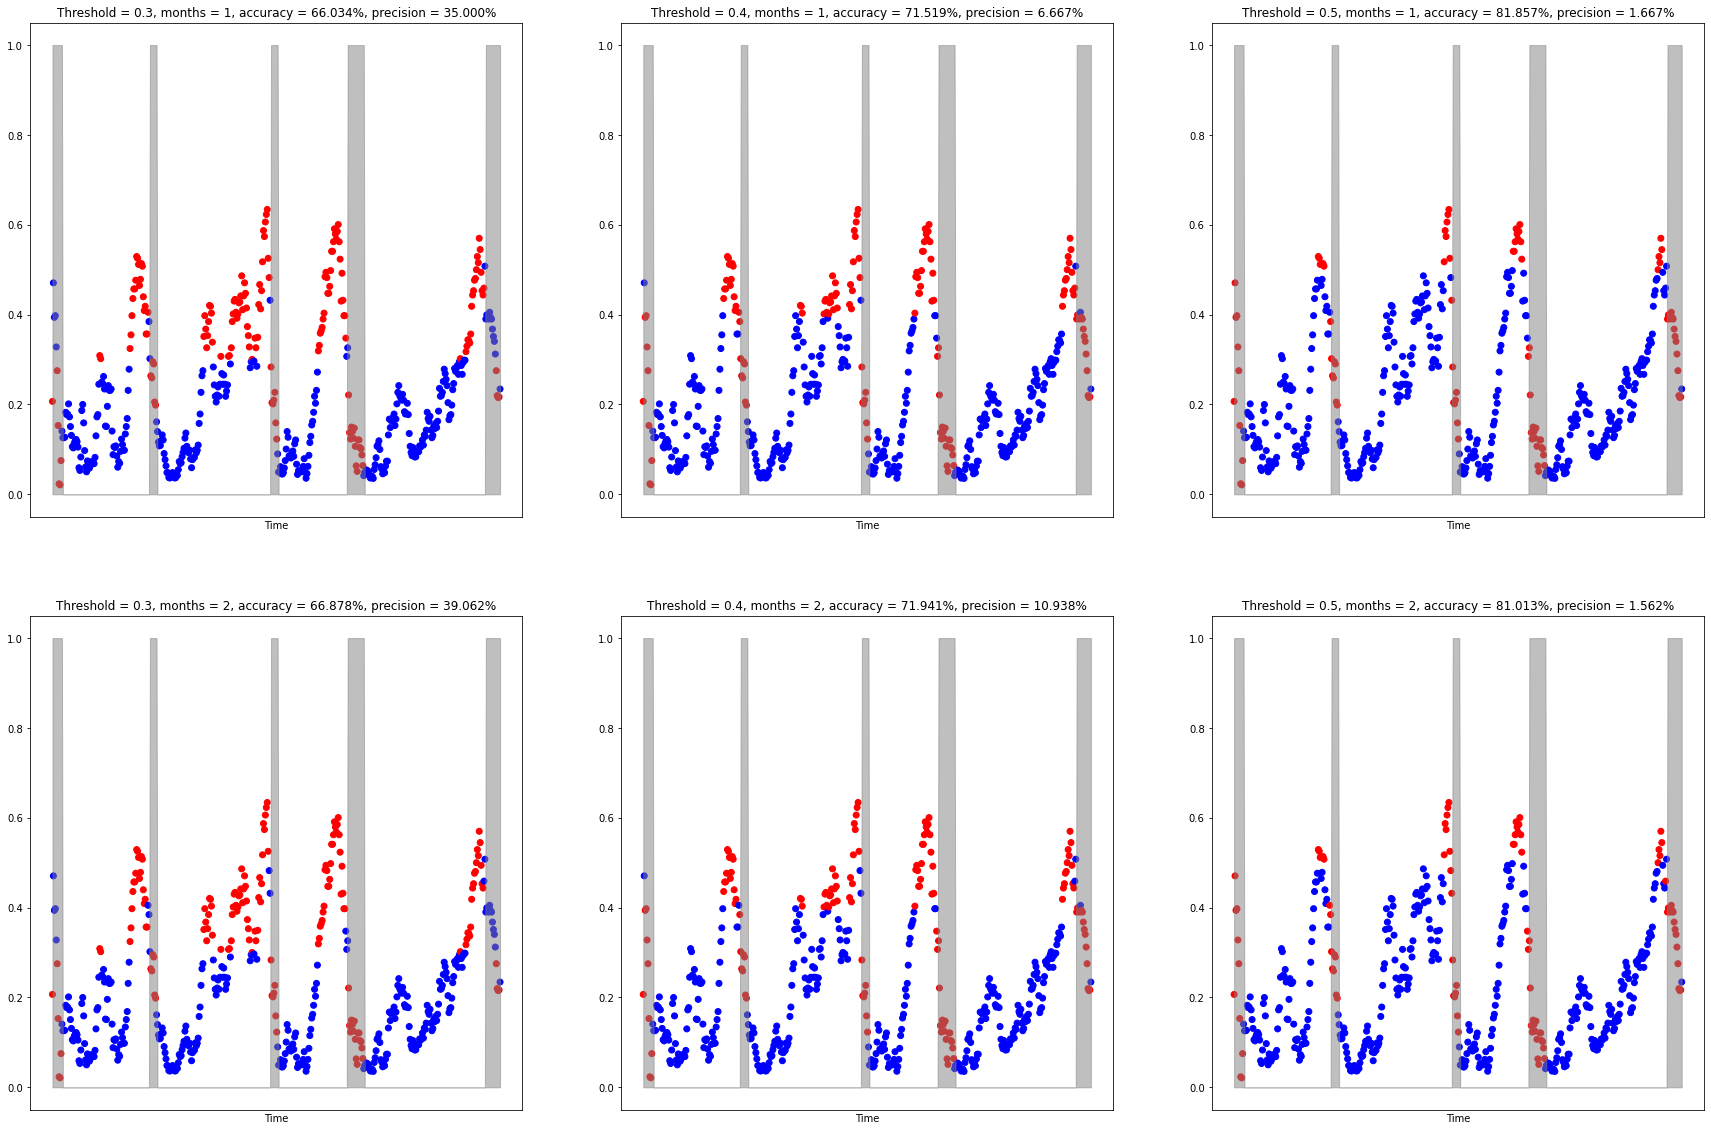

In [4]:
def activate(df, i, threshold, months):
    predict_rec = df.iloc[i]['y_hat'] >= threshold
    has_rec = (df.iloc[i + 1 : min(i + months + 1, len(df))]['USREC']).sum() > 0
    return predict_rec, has_rec

def accuracy(data):
    return np.int8(data).sum() / len(data)

def precision(predict_rec, has_rec):
    return np.int8(predict_rec & has_rec).sum() / np.int8(has_rec).sum()

def gen_colormap(data):
    colormap = np.empty(len(data), dtype=np.object)
    for i in range(len(data)):
        colormap[i] = 'blue' if data[i] else 'red'
    return colormap

def predict_recession(df, threshold, months):
    has_rec = np.empty(len(df), dtype=np.bool)
    predict_rec = np.empty(len(df), dtype=np.bool)
    for i in range(len(df)):
        predict_rec[i], has_rec[i] = activate(df, i, threshold, months)
    return predict_rec, has_rec

def plot_prediction(df, threshold, months):
    predict_rec, has_rec = predict_recession(df, threshold, months)
    res = (predict_rec == has_rec)
    plt.xticks([])
    plt.title('Threshold = {}, months = {}, accuracy = {:.3%}, precision = {:.3%}'.format(threshold, months, accuracy(res), precision(predict_rec, has_rec)))
    plt.xlabel('Time')
    plt.scatter(df['DATE'], df['y_hat'], c=gen_colormap(res))
    plt.fill_between(df['DATE'], df['USREC'], 0, color='grey', alpha=0.5)


plt.figure(figsize=(30, 20))
plt.subplot(2,3,1)
plot_prediction(df, 0.3, 1)
plt.subplot(2,3,2)
plot_prediction(df, 0.4, 1)
plt.subplot(2,3,3)
plot_prediction(df, 0.5, 1)
plt.subplot(2,3,4)
plot_prediction(df, 0.3, 2)
plt.subplot(2,3,5)
plot_prediction(df, 0.4, 2)
plt.subplot(2,3,6)
plot_prediction(df, 0.5, 2)

## Out-of-sample probit model on T10Y3MM
1. Use data 1982-2004(inclusive) to build initial model
2. For each month after 2004, predict

In [5]:
model = Probit(training_df['USREC'], training_df['T10Y3MM']).fit()
testing_df['y_hat'] = model.predict(testing_df['T10Y3MM'])

Optimization terminated successfully.
         Current function value: 0.398231
         Iterations 6


In [6]:
flag = False
starting_years = []


for i in range(len(df)):
    if flag:
        if not df.loc[i]['USREC']:
            flag = False
    else:
        if df.loc[i]['USREC']:
            flag = True
            starting_years.append((i, df.loc[i]['DATE']))
starting_years

[(0, '1982-01-01'),
 (103, '1990-08-01'),
 (231, '2001-04-01'),
 (312, '2008-01-01'),
 (458, '2020-03-01')]

In [7]:
a, b = predict_recession(df, 0.3, 2)
np.int8(a == b).sum() / np.int8(b).sum()

4.953125

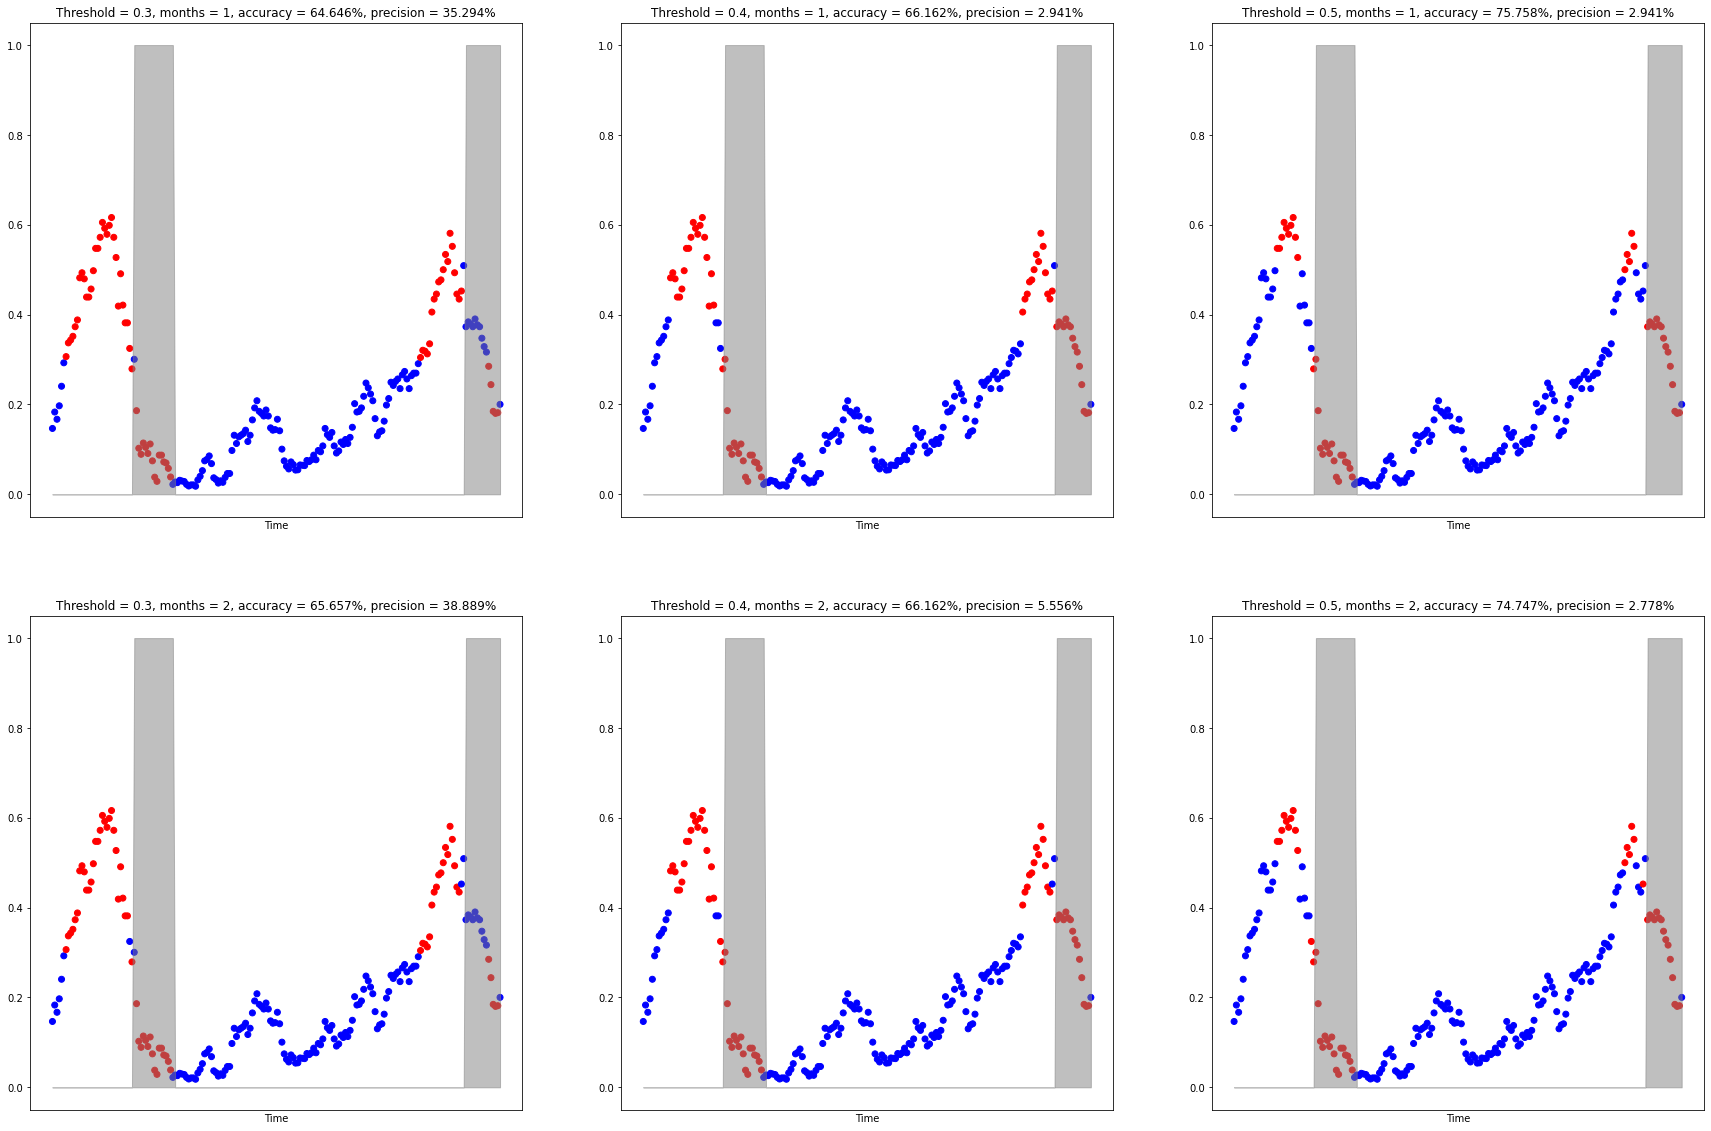

In [8]:
plt.figure(figsize=(30, 20))
plt.subplot(2,3,1)
plot_prediction(testing_df, 0.3, 1)
plt.subplot(2,3,2)
plot_prediction(testing_df, 0.4, 1)
plt.subplot(2,3,3)
plot_prediction(testing_df, 0.5, 1)
plt.subplot(2,3,4)
plot_prediction(testing_df, 0.3, 2)
plt.subplot(2,3,5)
plot_prediction(testing_df, 0.4, 2)
plt.subplot(2,3,6)
plot_prediction(testing_df, 0.5, 2)